In [1]:
from utils import Reader,show_xyz, show_lanes,show_clusters
import numpy as np 
from PIL import Image 
from plotly import graph_objects as go 
from scipy.spatial.transform import Rotation
import pandas as pd 
import datetime
from matplotlib import pyplot as plt
from scipy import interpolate 
from utils import line_distance, sort_lanes_by_axis, merge_two_lanes, lane_join,lanes_adjust
from scipy.optimize import linear_sum_assignment
%matplotlib inline

def draw_laneLines(laneLines: list,hilight_idx=-1):
    plt.figure(dpi=150)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for idx, lane in enumerate(laneLines):
        x, y = lane[:, 0], lane[:, 1]
        # k, b = np.polyfit(y, x, 1)
        # _y = np.linspace(y.min(), y.max(), 30)
        # _x = k * _y + b 
        c = colors[idx % len(colors)]
        if c == 'w':
            c = 'pink'
        plt.scatter(x, y,color=c, label=f'lane {idx}',s=0.5)
        # plt.scatter(_x, _y, color='black',alpha=0.5,s=0.5)
    if hilight_idx >=0:
        plt.scatter(laneLines[hilight_idx][:,0], laneLines[hilight_idx][:, 1], c='black')
    plt.axis('equal')
    if len(laneLines) < 16:
        plt.legend()
    # plt.legend()
    plt.show()

data_root = '/Users/yunzhi/Desktop/code/lane/data'
reader = Reader(data_root=data_root,read_img=False, gather_lane=False, lane_score_thr=0.3)
reader.info()

keys:  dict_keys(['laneLines', 'file_path', 'timestamp', 'displacement', 'quaternion', 'lane_global'])
len: 396
drop lane confidence < 0.3
drop empty, drop lane: len < 3


## drop global z > 30
## 10帧10帧的拼接，不用全部一起拼接

## 车道线展示

In [2]:
""" 
长: 3条主线
短: 五条主线
"""
reader.show_global_3d()

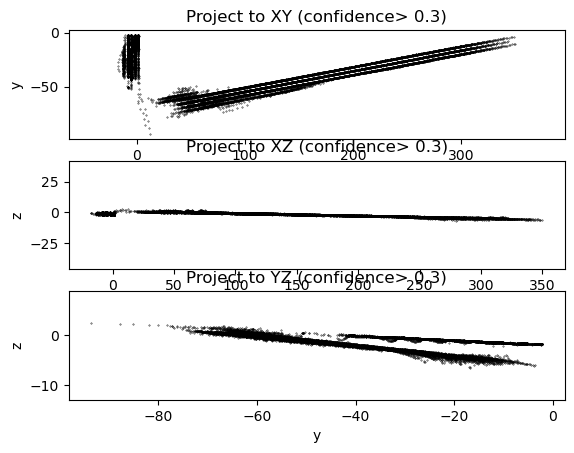

In [3]:
reader.show_global_2d()

## lane adjust 
- 根据每条车道线点数量做斜率的加权平均平滑斜率$\bar{k}$
- 根据$\bar{k}$和散点求$b_i=y_i-\bar{k}x_i$
- 重新采样插值出一条直线对齐

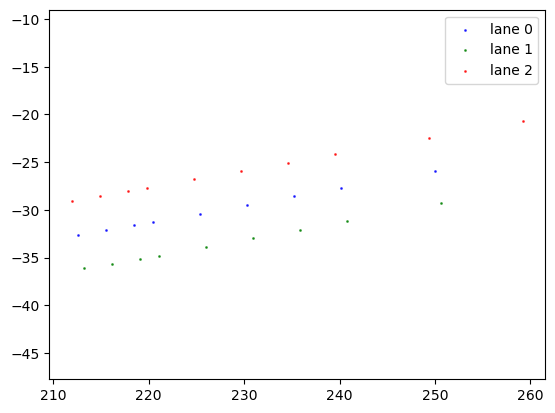

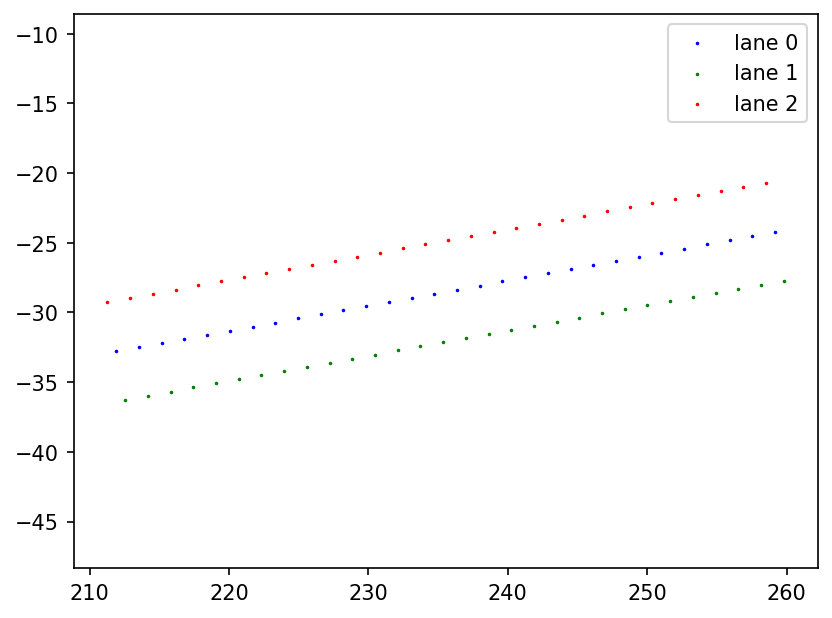

In [4]:
lane = reader.draw_single_lane(333)
draw_laneLines(lanes_adjust(lane))

## Lane Join:
- 根据两条直线取相同x或y坐标做对齐后的距离：线距离进行kNN聚类
- 可以有效的拼接单帧中断开的车道线

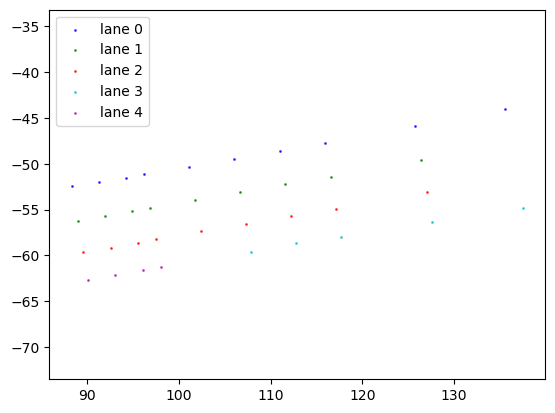

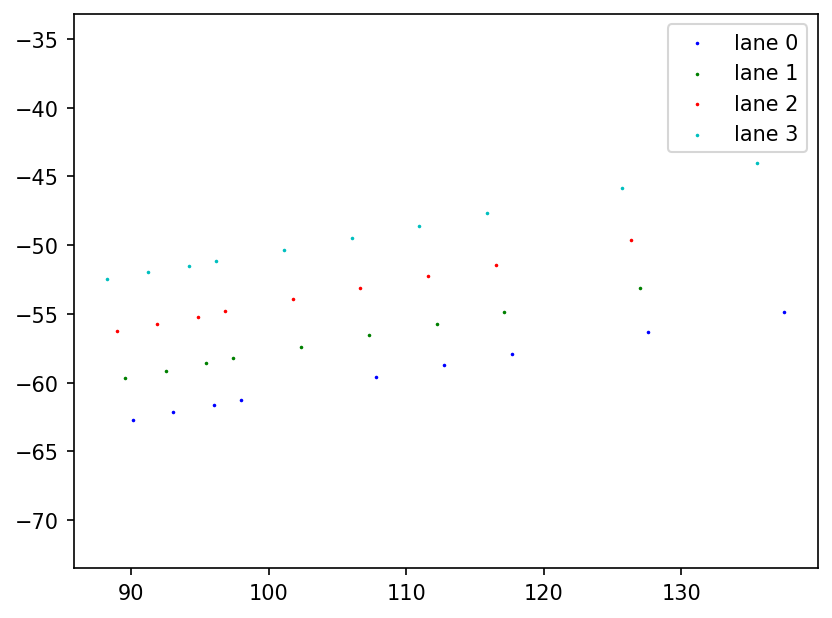

In [5]:
lane = reader.draw_single_lane(236)
draw_laneLines(lane_join(lane))

## 对帧与帧之间的拼接：
- 使用二分匹配，求前后帧线距离最小的车道线，根据前后帧的关系建图
- 图的每个联通分量都代表一条车道线
- dfs遍历图，dfs深度小的说明车道线拼接的段数小，车道线过短将被丢弃

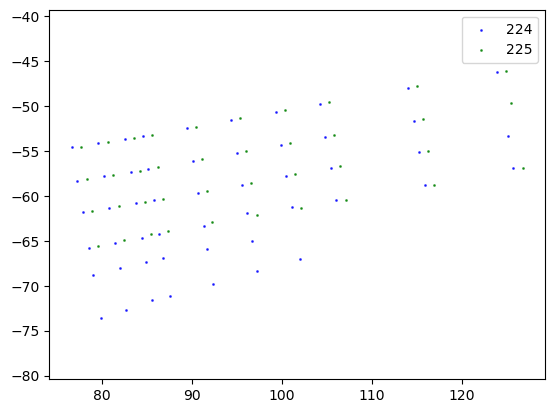

In [6]:
reader.draw_lanes_from_indice_2d([224, 225])

53


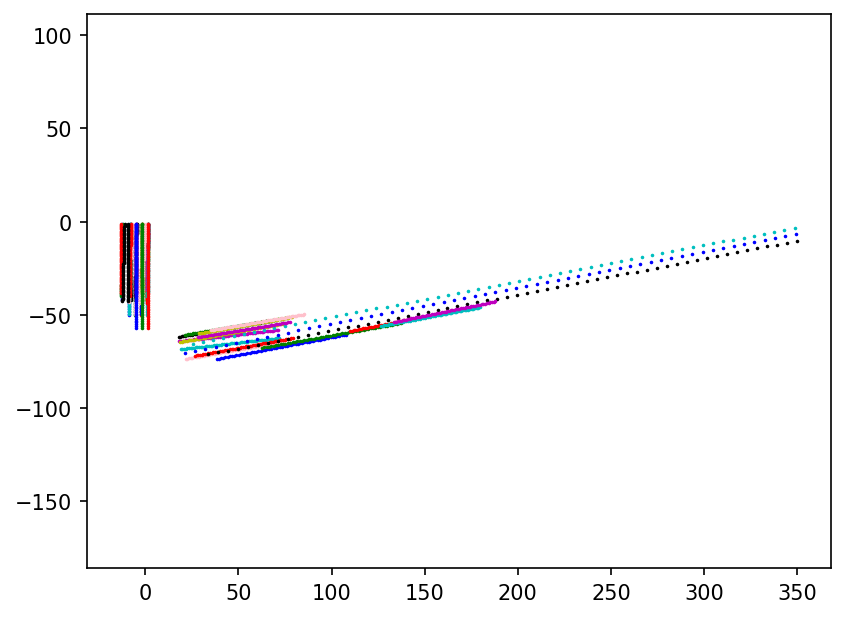

In [7]:
num_aligned=30
IoU_thr=0.5
distance_thr = 1.5
def dfs(graph: list, lanes_all:list, vis: list, i: int, j: int, root:np.ndarray, depth:int):
    # base case 1: boundary:
    if i>=len(graph) or vis[i][j]:
        return (root, depth)
    vis[i][j] = True
    # base case 2: -1
    if graph[i][j] == -1:
        if len(root) == 0:
            root = lanes_all[i][j]
        else:
            root = merge_two_lanes(root, lanes_all[i][j], axis=-1,num_points=-1)
        return (root, depth) 
    
    if len(root) == 0:
        root = lanes_all[i][j]
    _next = graph[i][j]
    root,depth = dfs(graph=graph, lanes_all=lanes_all, vis=vis, i=i+1, j=_next, root=root, depth=depth+1)
    return root,depth

def lanes_concat(reader, num_aligned=30, IoU_thr=0.5, distance_thr=1.5):
    lanes_all = []

    ############################################################
    ## 单独处理每一帧的车道线
    for idx, data in enumerate(reader):
        lanes = data['laneLines']
        lanes = sort_lanes_by_axis(lanes)

        # 连接断掉的车道线片段:
        lanes = lane_join(lanes, distance_thr=distance_thr,
                            IoU_thr=IoU_thr,
                            num_aligned=num_aligned,
                            mode='neighbor',sorted=True)

        # 让这一帧的车道线彼此平行
        lanes = lanes_adjust(lanes)

        # 平行后线距离变小可以去除冗余车道线
        lanes = lane_join(lanes, distance_thr=distance_thr,
                            IoU_thr=IoU_thr,
                            num_aligned=num_aligned,
                            mode='neighbor',sorted=True)
        lanes_all.append(lanes)
    ## ---------------------------------------------------------
    ############################################################

    ############################################################
    ## 二分匹配相邻帧的车道线得到graph,互相联通说明属于同一条车道线
    # 维护滑动窗口，使用窗口内的车道线做smooth和聚类
    window_size = 20
    l, r = 0, 0
    window = []
    graph = []
    while r < len(lanes_all):
        #####################
        # get current lanes:
        lanes_curr = lanes_all[r]
        # build next graph for current lanes:
        graph.append([-1 for i in range(len(lanes_curr))])
        if r == 0:
            window = lanes_curr   
            r += 1
            continue
        #####################

        # build bipartite graph:
        axis = -1
        cost = np.zeros((len(window), len(lanes_curr)))
        for i in range(len(window)):
            for j in range(len(lanes_curr)):
                cost_result = line_distance(window[i], lanes_curr[j])
                cost[i][j] = cost_result['distance']
                axis_window, axis_curr = cost_result['axis']
                axis = axis_curr
        # get min match
        row_ind, col_ind = linear_sum_assignment(cost)
        # print("row_ind:", row_ind)
        # print("col_ind:", col_ind)
        for i, j in zip(row_ind, col_ind):
            if cost[i][j] < distance_thr:
                # build graph:
                graph[r - 1][i] = j 
        r += 1
        window = lanes_curr 
        if r - l + 1 >= window_size:
            l += 1 
            
    ## ---------------------------------------------------------
    ############################################################

    ############################################################
    ## 拼接联通车道线:
    # print(graph)
    clusters = []
    vis = [[False for _ in range(len(lanes))] for lanes in graph]
    for i in range(len(graph)):
        for j in range(len(graph[i])):
            if vis[i][j]:
                continue
            clusters.append(dfs(graph=graph,
                                lanes_all=lanes_all,
                                vis=vis,
                                i=i, j=j,
                                root=np.array([]),
                                depth=0))
    lanes_clusters = [cluster[0] for cluster in clusters]
    depths = [cluster[1] for cluster in clusters]

    clusters = []
    # 丢弃短车道线
    for i in range(len(lanes_clusters)):
        if depths[i] >= 2:
            clusters.append(lanes_clusters[i])
    ## ---------------------------------------------------------
    ############################################################
    # print("clusters: ", len(clusters))
    # clusters = lane_join(clusters,distance_thr=distance_thr, mode='global')
    print(len(clusters))
    return clusters

clusters = lanes_concat(reader=reader)
draw_laneLines(clusters)

## 使用每条车道线的中心点kNN聚类车道线：
- 合并短小的噪声车道线到主车道线

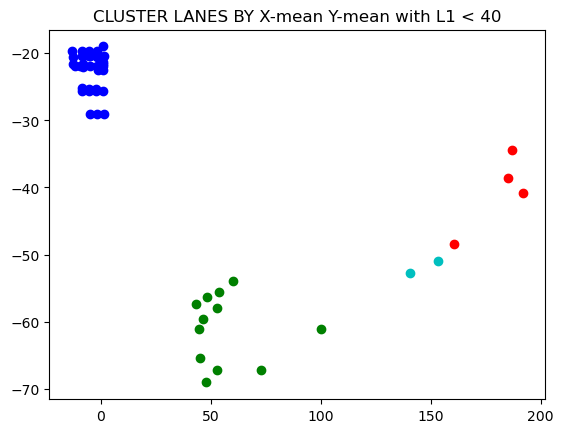

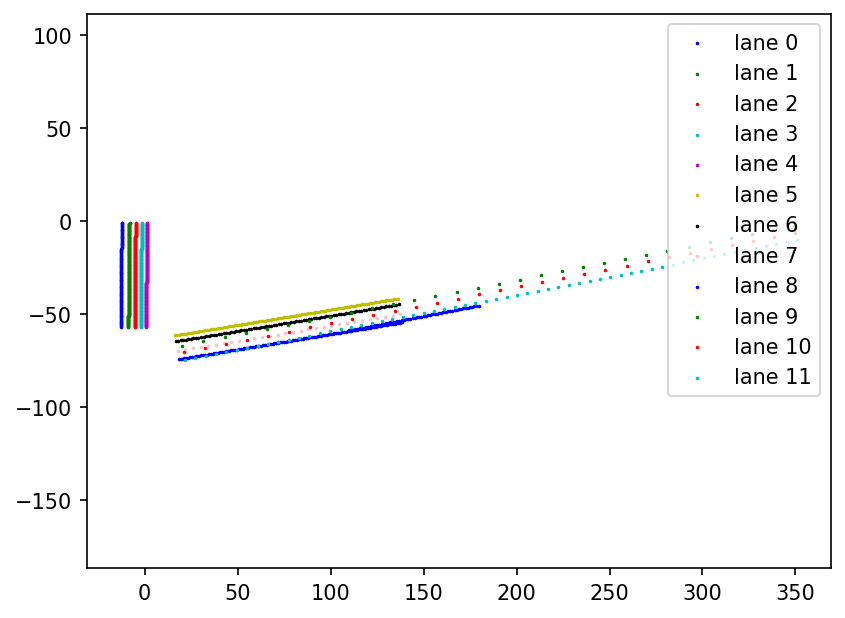

12


In [8]:
def cos_similarity(k1:float, k2:float):
    return (1 + k1 * k2) / np.sqrt(1 + k1 ** 2 + k2 ** 2 + k1 ** 2 * k2 ** 2)

def cluster_lanes_by_mean(lanes, thr=40):
    # print("len lanes: ", len(lanes))
    Means = []
    for lane in lanes:
        x, y = lane[:, 0].mean(), lane[:, 1].mean()
        Means.append((x,y))

    # print(Ks)
    # print(len(Ks))
    clusters = []
    for i, (x_mean, y_mean) in enumerate(Means):
        if len(clusters) == 0:
            clusters.append([i])
            continue 
        not_found = True 

        for j, cluster in enumerate(clusters):
            for _, cor_idx in enumerate(cluster):
                _x, _y = Means[cor_idx]
                sim = abs(_x - x_mean) + abs(_y - y_mean)
                if sim < thr:
                    clusters[j].append(i)
                    not_found = False
                    break
            if not not_found:
                break

        if not_found:
            clusters.append([i])
            continue 
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray','pink']
    for c, cluster in enumerate(clusters):
        xy = [Means[i] for i in cluster]
        xy = np.array(xy)
        plt.scatter(xy[:,0],xy[:,1],c=colors[c])
    plt.title(f"CLUSTER LANES BY X-mean Y-mean with L1 < {thr}")
    plt.show()

    return clusters
indice = cluster_lanes_by_mean(lanes=clusters)
# print(f"indice of len {len(indice)}: ",indice)
_clusters = [] 
for cluster_indice in indice:
    _clusters.append([clusters[index] for index in cluster_indice])

for i,cluster in enumerate(_clusters):
    _clusters[i] = lanes_adjust(cluster)
    _clusters[i] = lane_join(_clusters[i],distance_thr=7.5)
lane_lines = []
for cluster in _clusters:
    lane_lines += cluster
lane_lines = lane_join(lane_lines,mode='global')
draw_laneLines(lane_lines)

print(len(lane_lines))

12


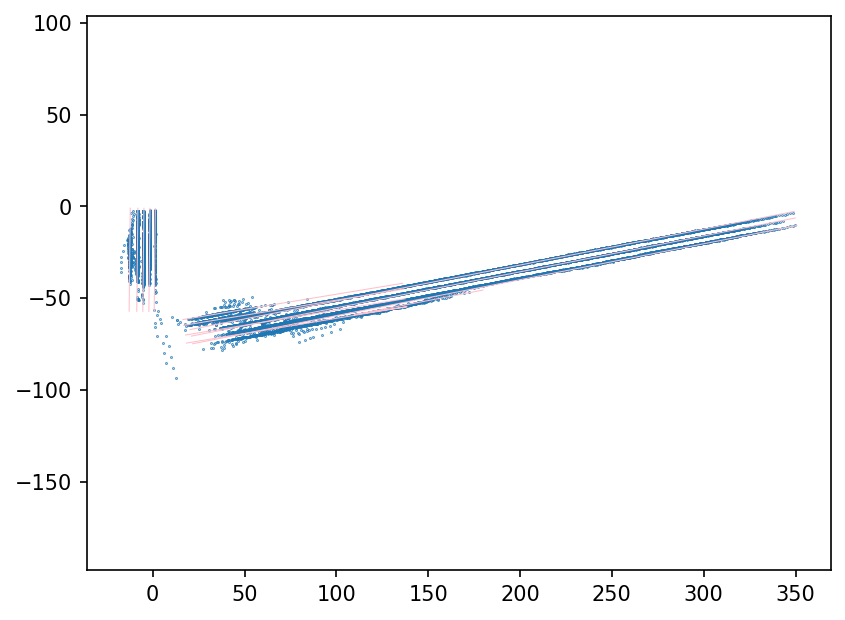

In [9]:
plt.figure(dpi=150)
points_all = np.concatenate([data['lane_global'] for data in reader.data_infos if 'lane_global' in data],axis=0)
_X = points_all[:,0]
_Y = points_all[:,1]
_Z = points_all[:,2]
for i,lane in enumerate(lane_lines):
    x, y = lane[:, 0], lane[:, 1]
    plt.plot(x, y, c='pink',linewidth=0.5)
plt.scatter(_X, _Y, s=0.1)
plt.axis('equal')
print(len(lane_lines))

In [10]:
class Lane(object):
    def __init__(self,lane_arry:np.ndarray, axis=-1,k=-1,b=-1) -> None:
        x, y = lane_arry[:, 0], lane_arry[:, 1]
        if axis == -1:
            k, b = np.polyfit(x, y, 1)
            if abs(k) > 1:
                k, b = np.polyfit(y, x, 1)
                axis = 1
            else:
                axis = 0
        self.k = k 
        self.b = b 
        self.axis = axis
        self.points = lane_arry
    
    def interp(self, num_points=30):
        if self.axis == 0:
            x_min, x_max = self.points[:, 0].min(), self.points[:, 0].max()
            x_samples = np.linspace(x_min, x_max, num_points)
            y = self.k * x_samples + self.b 
            return np.stack([x_samples, y]).T 
        elif self.axis == 1:
            y_min, y_max = self.points[:, 1].min(), self.points[:, 1].max()
            y_samples = np.linspace(y_min, y_max, num_points)
            x = self.k * y_samples + self.b 
            return np.stack([x, y_samples]).T 
        else:
            raise ValueError
    
    def plot(self, color=None):
        points = self.interp()
        plt.scatter(points[:, 0], points[:, 1], c=color)
        plt.axis('equal')
        plt.show()        

In [11]:
dist = np.zeros((len(lane_lines), len(_Z)))
Lanes = []
for i, lane in enumerate(lane_lines):

    # get k, b in lane:
    axis = 0
    k, b = np.polyfit(lane[:, 0], lane[:, 1], 1)
    if abs(k) > 1:
        axis = 1
        k, b = np.polyfit(lane[:, 1], lane[:, 0], 1)
    Lanes.append(Lane(lane, axis=axis, k=k, b=b))
    for j, (x, y) in enumerate(zip(_X, _Y)):
        if axis == 0:
            # y = k * x + b
            distance = abs(y - k * x - b) / np.sqrt(1 + k ** 2)
        else:
            # x = k * y + b
            distance = abs(x - k * y - b) / np.sqrt(1 + k ** 2)
        dist[i][j] = distance
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray','pink']
argmin = dist.argmin(axis=0)

# 过滤离群点:
dist = dist[argmin, np.arange(len(argmin))]
inds = dist<dist.mean() * 2
_X = _X[inds]
_Y = _Y[inds]
_Z = _Z[inds]
argmin = argmin[inds]

In [12]:
# update link for each road if first road:    

In [13]:
# for i, lane in enumerate(Lanes):
#     inds = argmin == i 
#     # 取出车道线i的散点:
#     _x = _X[inds]
#     _y = _Y[inds]
#     _z = _Z[inds]

#     axis = lane.axis
#     k = lane.k 
#     b = lane.b 
    

In [14]:
# from IPython.display import IFrame
# plt.scatter(_X, _Y, s=0.5, c='yellow',alpha=0.4)
# plt.scatter(_X[inds], _Y[inds], s=0.5,c='black')
# plt.axis('equal')
# plt.savefig('cache_scatter.pdf', format='pdf', bbox_inches='tight')
# IFrame('cache_scatter.pdf', width=400,height=300)

In [15]:
# for i in range(len(lane_lines)):
#     indice = argmin == i 
#     indice *= ()
#     x = _X[indice]
#     y = _Y[indice]
#     plt.scatter(x, y, c=colors[i%len(colors)],s=0.5)